In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [3]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

<font size='20'>
    <b>
        Principal Component Analysis
    </b>
</font>

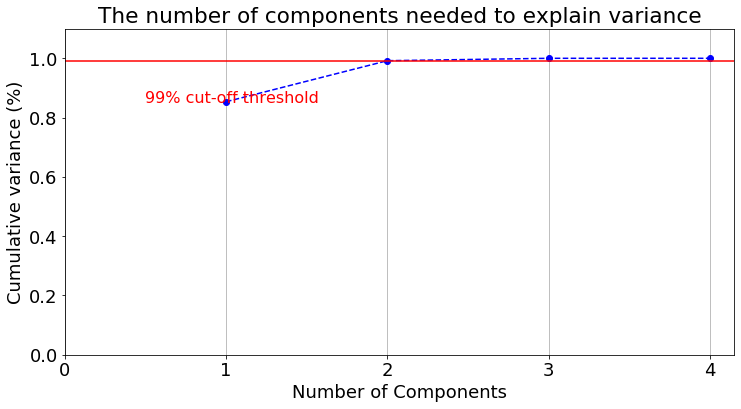

In [6]:
### Setup 
data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

### Determine Number of factors
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Keep 3 factors 2 is on the cusp but keeping three just to make sure

<font size='20'>
    <b>
        Ordinary Least Squares
    </b>
</font>

In [8]:
### Find all models

#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3

#find all possible models
models = []
models_str = []
all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]
for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))

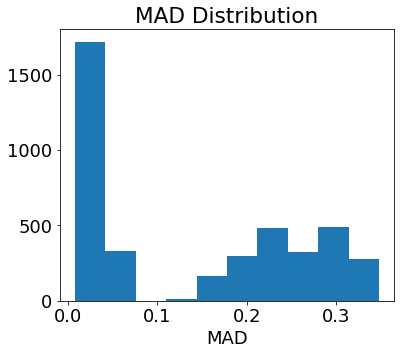

0.007616242213104307
['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu']
[ 9.38558878e+00  4.52603736e-02 -6.04406934e-02 -2.97535635e+00
  1.90507626e-02 -5.46867463e-02  1.09884832e-01 -5.87878556e-03
  2.50949914e-02  8.73273520e-01 -2.91548163e-05  2.28253331e-02]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.794e+06
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:51:36   Log-Likelihood:                 42646.
No. Observations:               14946   AIC:                        -8.527e+04
Df Residuals:                   14934   BIC:                        -8.518e+04
Df Model:                          11                                         
Co

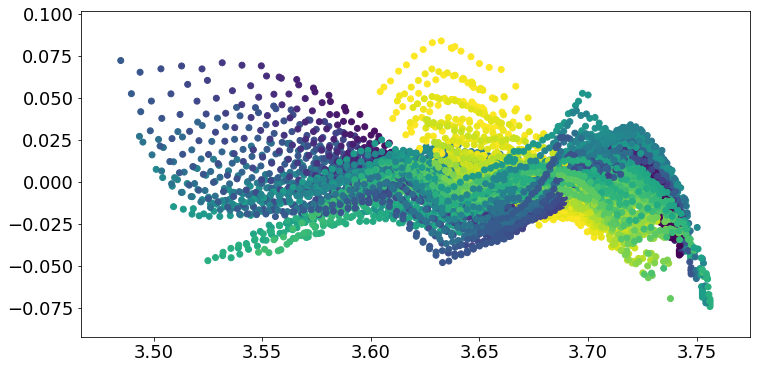

In [9]:
### Check OLS Model

plt.figure(figsize=[6,5])
plt.hist(mads)
plt.title(r'MAD Distribution')
plt.xlabel(r'MAD')
plt.show()

print(np.asarray(mads)[np.asarray(mads).argmin()])
print(models_str[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])
print(summaries[np.asarray(mads).argmin()])

plt.scatter(parsec['logTe'],resids[np.asarray(mads).argmin()],c=parsec['int_IMF'])

Get rid of x1cu as coefficient so tiny

In [10]:
### fit with x1cu removed

parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x3sq, x2cu]).T
parsimonious = np.array([x1, x2, x3, x12, x13, x23, x1sq, x2sq, x3sq, x2cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.973e+06
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:54:22   Log-Likelihood:                 42644.
No. Observations:               14946   AIC:                        -8.527e+04
Df Residuals:                   14935   BIC:                        -8.518e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3856      0.000   4.14e+04      0.0

In [13]:
### Final Age Model

def find_ages(z1,z2,z3):
    p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
         1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
    return age

<font size='20'>
    <b>
        Calculate Ages and Errors for APOGEE
    </b>
</font>

In [14]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [15]:
### Age Distributions No Offsets

age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_noise(dist,1.0,distribution='uniform')
#             absK_new = afunc.absmag(ks_new,dist_new) - ak
        
#         else:
#             absK_new = afunc.absmag(ks_new,dist) - ak
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in range(len(age_dist)):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

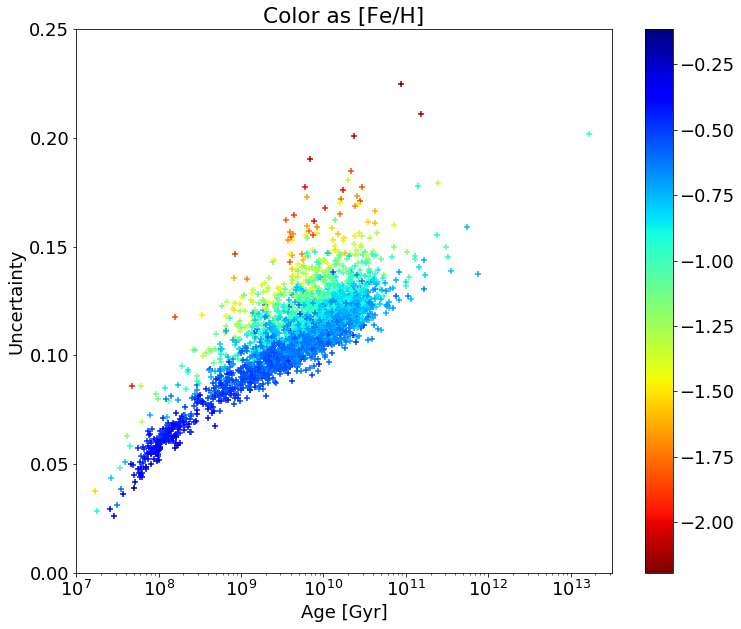

In [29]:
### Plot Uncertainties as Function of Age 

plt.figure(figsize=[12,10])

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Age [Gyr]')
plt.ylabel(r'Uncertainty')

plt.xscale('log')

plt.xlim(10**7,10**13.5)
plt.ylim(0,0.25)


plt.scatter(10**np.asarray(parages),np.asarray(devs),marker='+',c=r13['FE_H'],cmap='jet_r',label='No Offset')
plt.colorbar()

plt.show()

In [35]:
### Offset 1 kpc

age_dist1 = []
offset = 1. # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist1.append(noise_ages)

parages1 = [] 
devs1 = []
for k in range(len(age_dist1)):
    devs1.append(afunc.mad(age_dist1[k]))
    parages1.append(np.median(age_dist1[k]))

In [36]:
### Offset 2.5 kpc

age_dist2_5 = []
offset = 2.5 # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist2_5.append(noise_ages)

parages2_5 = [] 
devs2_5 = []
for k in range(len(age_dist2_5)):
    devs2_5.append(afunc.mad(age_dist2_5[k]))
    parages2_5.append(np.median(age_dist2_5[k]))

In [37]:
### Offset 5 kpc

age_dist5 = []
offset = 5. # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist5.append(noise_ages)

parages5 = [] 
devs5 = []
for k in range(len(age_dist5)):
    devs5.append(afunc.mad(age_dist5[k]))
    parages5.append(np.median(age_dist5[k]))

In [38]:
### Offset 7_5 kpc

age_dist7_5 = []
offset = 7.5 # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist7_5.append(noise_ages)

parages7_5 = [] 
devs7_5 = []
for k in range(len(age_dist7_5)):
    devs7_5.append(afunc.mad(age_dist7_5[k]))
    parages7_5.append(np.median(age_dist7_5[k]))

In [39]:
### Offset 10 kpc

age_dist10 = []
offset = 10. # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist10.append(noise_ages)

parages10 = [] 
devs10 = []
for k in range(len(age_dist10)):
    devs10.append(afunc.mad(age_dist10[k]))
    parages10.append(np.median(age_dist10[k]))

In [58]:
### Offset 15 kpc

age_dist15 = []
offset = 15. # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1500):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*15**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*15**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist15.append(noise_ages)

parages15 = [] 
devs15 = []
for k in range(len(age_dist15)):
    devs15.append(afunc.mad(age_dist15[k]))
    parages15.append(np.median(age_dist15[k]))

In [59]:
### Offset 20 kpc

age_dist20 = []
offset = 20. # kpc

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(2000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = afunc.absmag(ks_new,dist+offset) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*20**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*20**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist20.append(noise_ages)

parages20 = [] 
devs20 = []
for k in range(len(age_dist20)):
    devs20.append(afunc.mad(age_dist20[k]))
    parages20.append(np.median(age_dist20[k]))

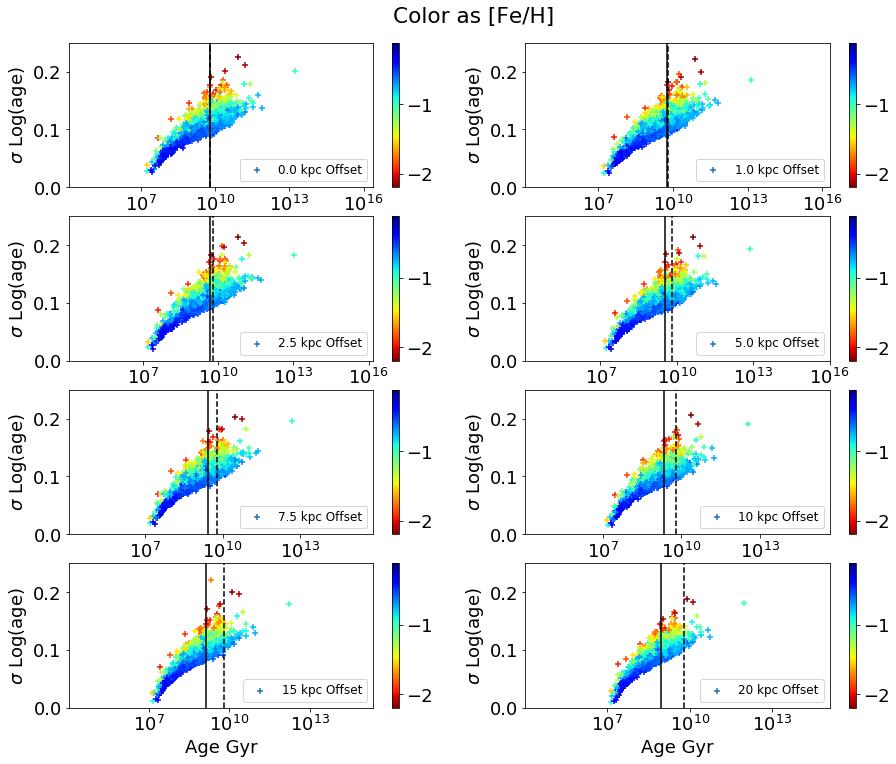

In [186]:
### Uncertainty as a function of age with distance offsets

plots = [821,822,823,824,825,826,827,828]
logages = [parages,parages1,parages2_5,parages5,parages7_5,parages10,parages15,parages20]
agedevs = [devs,devs1,devs2_5,devs5,devs7_5,devs10,devs15,devs20]
offsets = [0.0,1.0,2.5,5.0,7.5,10,15,20]

plt.figure(figsize=[15,25])
plt.suptitle(r'Color as [Fe/H]',y=0.9)
plt.ylabel(r'Uncertainty')
# plt.text()
for i in range(len(plots)):
    plt.subplot(plots[i])
    plt.ylabel(r'$\sigma$ Log(age)')
    plt.xscale('log')
    plt.ylim(0,0.25)
    plt.scatter(10**np.asarray(logages[i]),np.asarray(agedevs[i]),marker='+',c=r13['FE_H'],cmap='jet_r',
                label='{} kpc Offset'.format(offsets[i]))
    plt.colorbar()
    plt.axvline(10**np.median(np.asarray(logages[0])),c='k',ls='--')
    plt.axvline(10**np.median(np.asarray(logages[i])),c='k',ls='-')
    
    plt.legend(loc='lower right',fontsize='12')
    
    if plots[i] in [827,828]:
        plt.xlabel(r'Age Gyr')

plt.savefig('age_uncert.pdf',bbox_inches='tight')
plt.show()

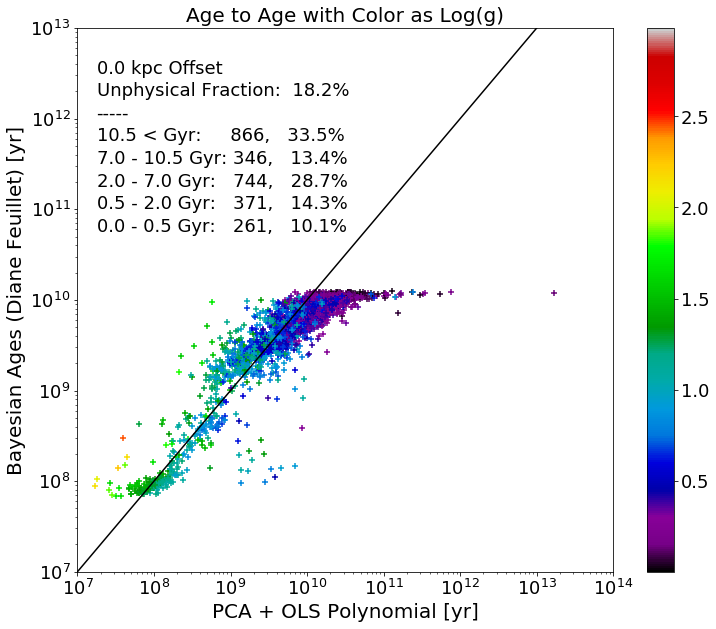

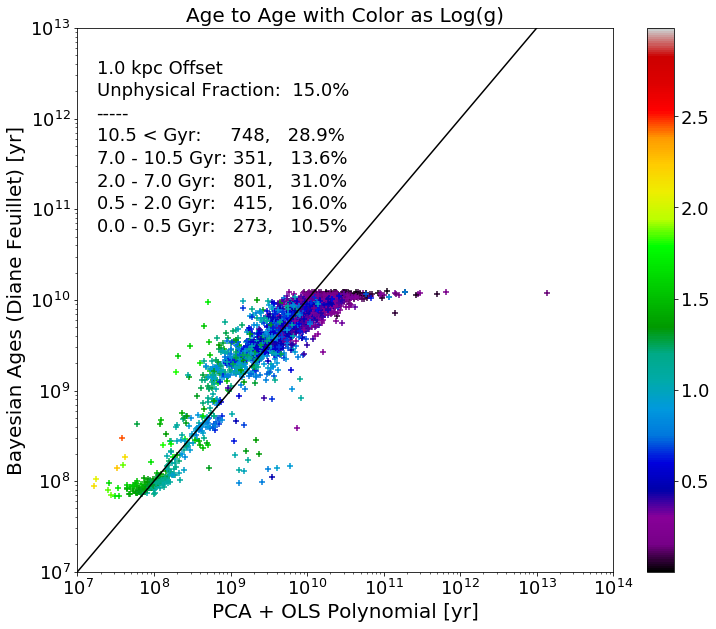

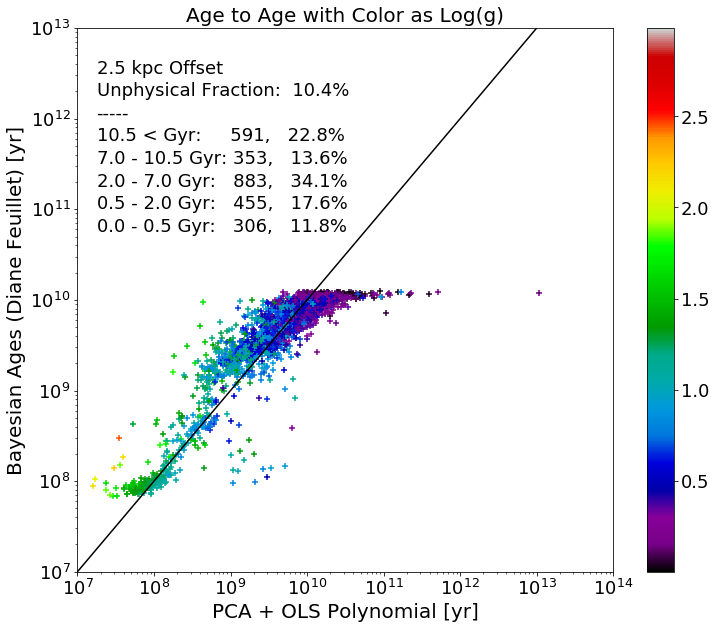

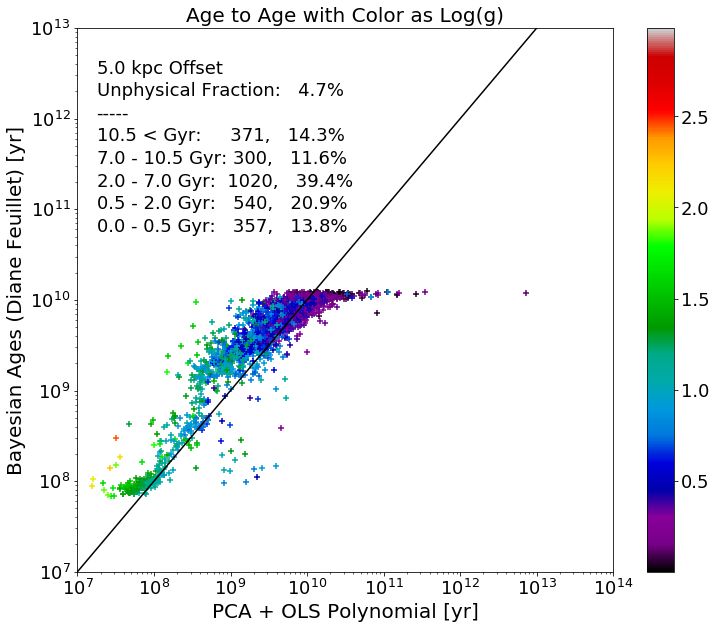

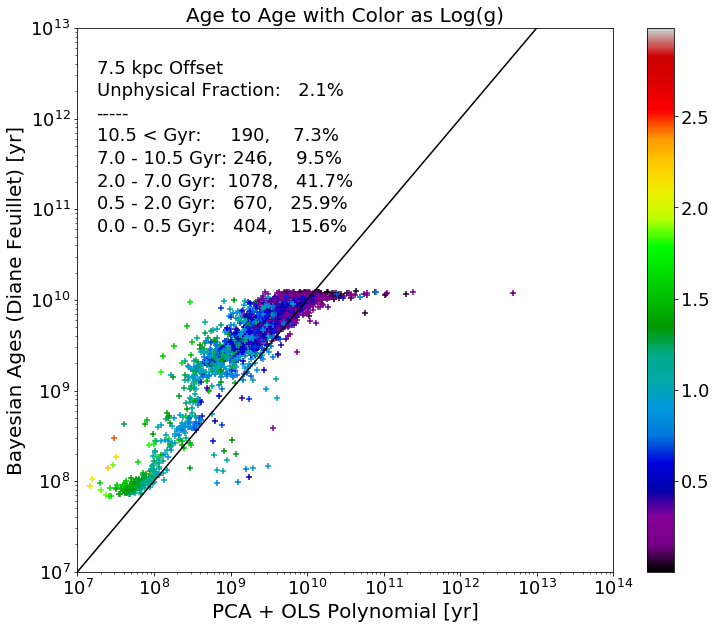

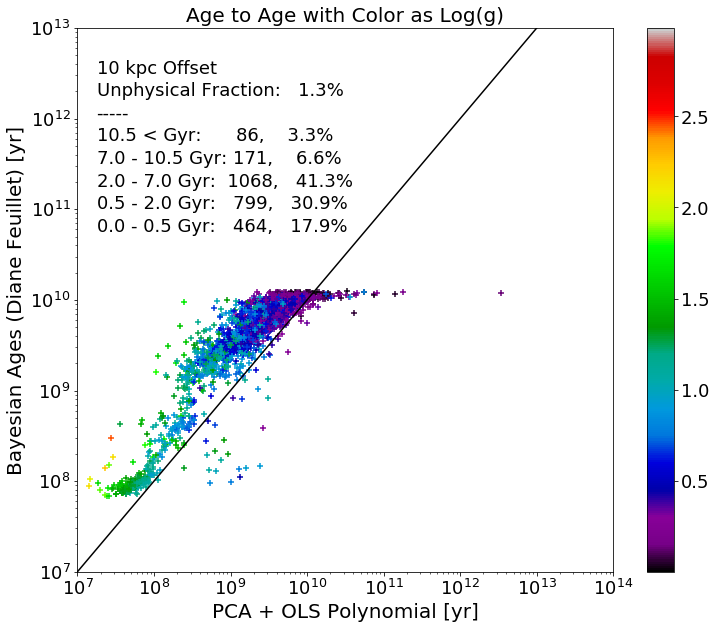

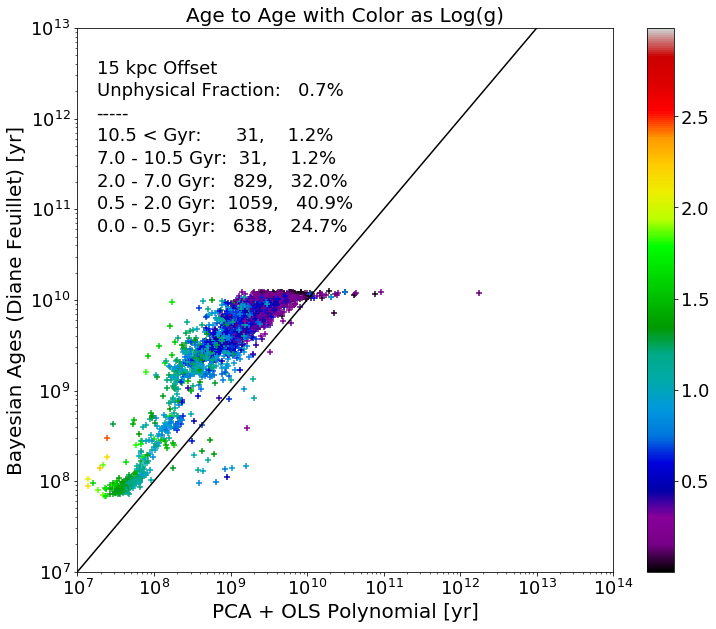

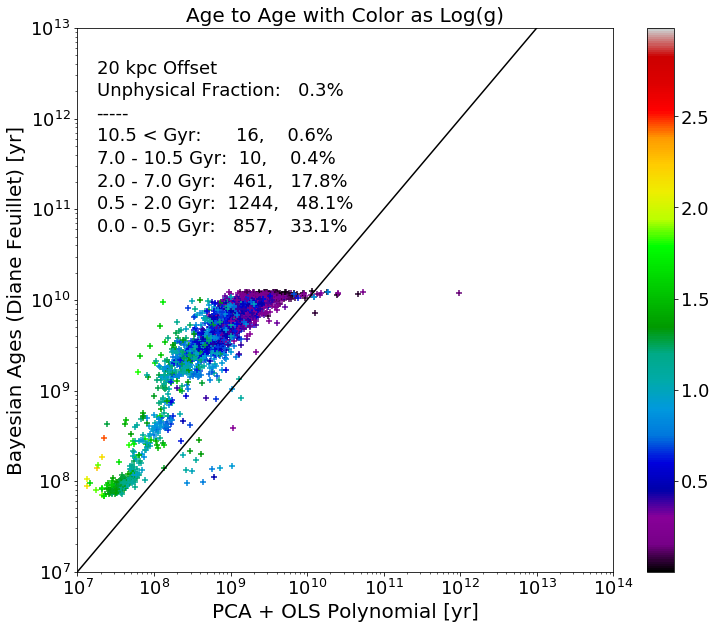

In [187]:
### Compare to Diane with Distance Offsets

for i in range(len(logages)):
    
    young_num = len(np.squeeze(np.where(logages[i]<=np.log10(0.5*10**9))))
    yless_num = len(np.squeeze(np.where((logages[i]>np.log10(0.5*10**9))&(logages[i]<=np.log10(2.0*10**9)))))
    ymed_num = len(np.squeeze(np.where((logages[i]>np.log10(2.0*10**9))&(logages[i]<=np.log10(7*10**9)))))
    omed_num = len(np.squeeze(np.where((logages[i]>np.log10(7*10**9))&(logages[i]<=np.log10(10.5*10**9)))))
    old_num = len(np.squeeze(np.where(logages[i]>np.log10(10.5*10**9))))
    
    # setup
    plt.figure(figsize=[12,10])
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel(r'PCA + OLS Polynomial [yr]',fontsize=20)
    plt.ylabel(r'Bayesian Ages (Diane Feuillet) [yr]',fontsize=20)
    plt.title(r'Age to Age with Color as Log(g)',fontsize=20)
    
    un_frac = len(np.squeeze(np.where(logages[i]>np.log10(ageU)+np.median(agedevs[i]))))/len(logages[i])
    
    # unphysical 
    plt.text(10**7.25,10**12.5,'{} kpc Offset'.format(offsets[i]))
    plt.text(10**7.25,10**12.,'-----')
    
    plt.text(10**7.25,10**12.25,'Unphysical Fraction: {:>5.1f}%'.format(un_frac*100))
    
#     plt.text(10**7.5,10.12)
    
    # age bin members
    plt.text(10**7.25,10**10.75,'0.0 - 0.5 Gyr: {:>5},  {:>5.1f}%'.format(young_num,
                                                            float(young_num)*100/float(len(logages[i]))))
    plt.text(10**7.25,10**11.0,'0.5 - 2.0 Gyr: {:>5},  {:>5.1f}%'.format(yless_num,
                                                               float(yless_num)*100/float(len(logages[i]))))
    plt.text(10**7.25,10**11.25,'2.0 - 7.0 Gyr: {:>5},  {:>5.1f}%'.format(ymed_num,
                                                            float(ymed_num)*100/float(len(logages[i]))))
    plt.text(10**7.25,10**11.5,'7.0 - 10.5 Gyr: {:>3},  {:>5.1f}%'.format(omed_num,
                                                                float(omed_num)*100/float(len(logages[i]))))
    plt.text(10**7.25,10**11.75,'10.5 < Gyr: {:>7},  {:>5.1f}%'.format(old_num,
                                                           float(old_num)*100/float(len(logages[i]))))
    
    # plot data comparing to Diane's ages
    plt.scatter(10**np.asarray(logages[i])[r13_ind],10**pdfout['P_MEAN'][pdfout_ind],c=r13['LOGG'][r13_ind],
                marker='+',cmap='nipy_spectral',label='{} kpc Offset'.format(offsets[i]))
    plt.colorbar()
    
    plt.plot(10**np.array([7,8,9,10,11,12,13]),10**np.array([7,8,9,10,11,12,13]),c='k')
    plt.ylim(10**7,10**13)
    plt.xlim(10**7,10**14)
    
    plt.savefig('offset{}_compare_2_feuillet.pdf'.format(offsets[i]),bbox_inches='tight')
    
    plt.show()
    

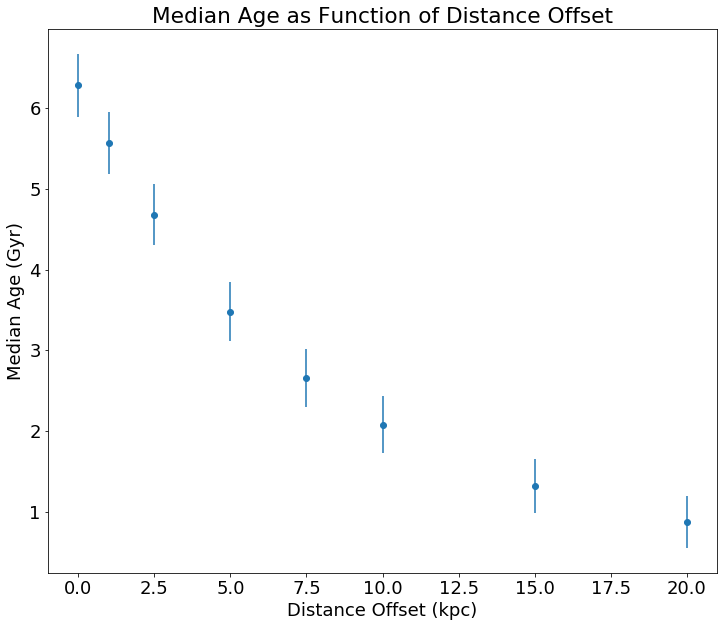

In [188]:
med_ages = []
max_ages = []
min_ages = []
mad_ages = []
for i in range(len(logages)):
    med_ages.append(np.nanmedian(logages[i]))
    max_ages.append(np.nanmax(logages[i]))
    min_ages.append(np.nanmin(logages[i]))
    mad_ages.append(afunc.mad(logages[i]))

plt.figure(figsize=[12,10])
plt.errorbar(offsets,10**np.asarray(med_ages)/10**9,yerr=mad_ages,ls='none',marker='o')
plt.ylabel(r'Median Age (Gyr)')
plt.xlabel(r'Distance Offset (kpc)')
plt.title(r'Median Age as Function of Distance Offset')
plt.savefig('med_ages_offset.pdf',bbox_inches='tight')
plt.show()

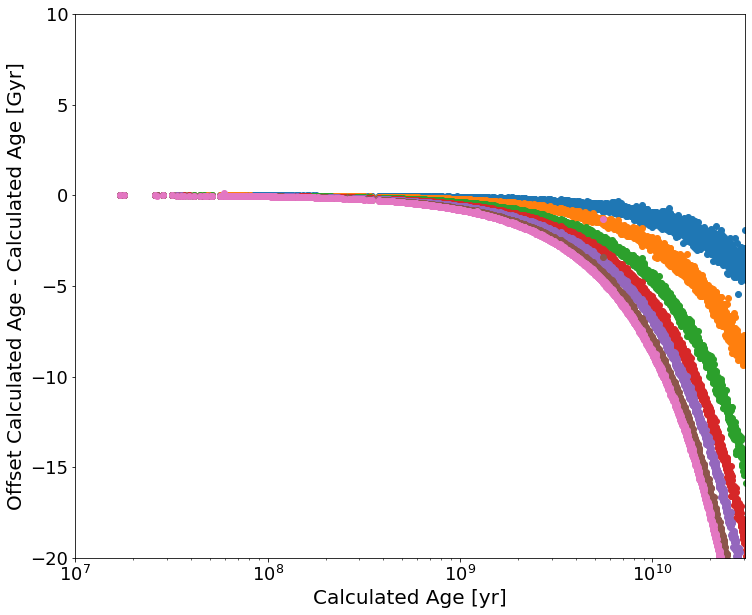

In [229]:
#Offsets as as function of 

offsets = [1.,2.5,5.,7.5,10.,15.,20.]

diffs = [10**np.asarray(parages1)-10**np.asarray(parages),10**np.asarray(parages2_5)-10**np.asarray(parages),
         10**np.asarray(parages5)-10**np.asarray(parages),10**np.asarray(parages7_5)-10**np.asarray(parages),
         10**np.asarray(parages10)-10**np.asarray(parages),10**np.asarray(parages15)-10**np.asarray(parages),
         10**np.asarray(parages20)-10**np.asarray(parages)]


plt.figure(figsize=[12,10])
for i in range(len(diffs)):
    
#     # setup
    
    plt.xscale('log')
    
    plt.xlabel(r'Calculated Age [yr]',fontsize=20)
    plt.ylabel(r'Offset Calculated Age - Calculated Age [Gyr]',fontsize=20)
    
    plt.scatter(10**np.asarray(parages),diffs[i]/10**9)
    
    plt.ylim(-20,10)
    plt.xlim(10**7,10**(10.13+0.35))


#     plt.colorbar()
    
# #     plt.savefig('offset{}_vs_calc_age.pdf'.format(offsets[i]),bbox_inches='tight')
    
plt.show()

In [284]:
diffs = np.array([10**np.asarray(parages1)-10**np.asarray(parages),
                  10**np.asarray(parages2_5)-10**np.asarray(parages),
                  10**np.asarray(parages5)-10**np.asarray(parages),
                  10**np.asarray(parages7_5)-10**np.asarray(parages),
                  10**np.asarray(parages10)-10**np.asarray(parages),
                  10**np.asarray(parages15)-10**np.asarray(parages),
                  10**np.asarray(parages20)-10**np.asarray(parages)])

gdiffs = diffs/10**9



(array([ 11.,  23.,  28.,  29.,  28.,  42.,  46.,  38.,  45.,  74.,  71.,
         93., 107., 132., 141., 181., 196., 264., 299.]),
 array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1]),
 <a list of 19 Patch objects>)

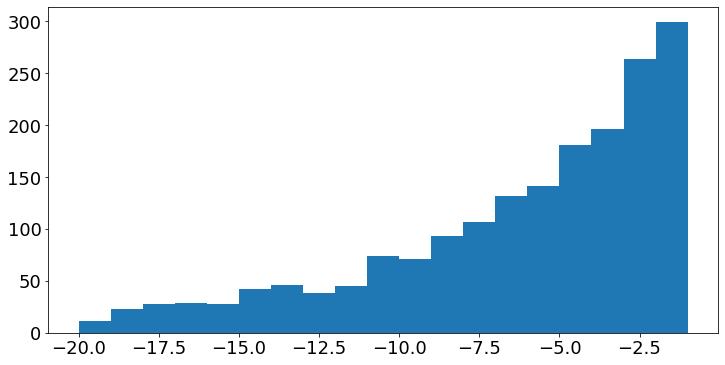

In [298]:
plt.hist(gdiffs[3],range(-20,0))


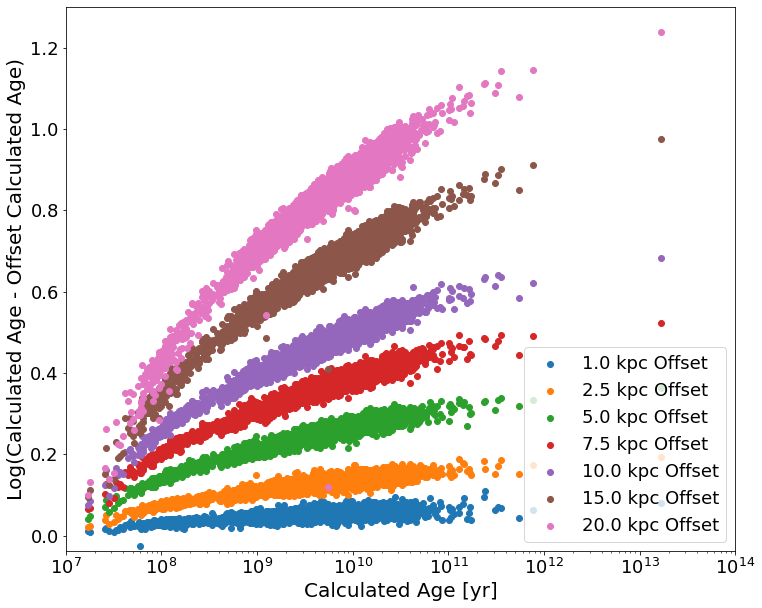

In [264]:

offsets = [1.0,2.5,5.0,7.5,10.0,15.0,20.0]

diffs = np.array([-np.asarray(parages1)+np.asarray(parages),-np.asarray(parages2_5)+np.asarray(parages),
         -np.asarray(parages5)+np.asarray(parages),-np.asarray(parages7_5)+np.asarray(parages),
         -np.asarray(parages10)+np.asarray(parages),-np.asarray(parages15)+np.asarray(parages),
         -np.asarray(parages20)+np.asarray(parages)])

diffs = diffs #np.log10(diffs)

plt.figure(figsize=[12,10])
for i in range(len(diffs)):
    
#     # setup
    
    plt.xscale('log')
#     plt.yscale('log')
    
    plt.xlabel(r'Calculated Age [yr]',fontsize=20)
    plt.ylabel(r'Log(Calculated Age - Offset Calculated Age)',fontsize=20)
    
    plt.scatter(10**np.asarray(parages),diffs[i],label='{} kpc Offset'.format(offsets[i]))
    
    plt.ylim(top=1.3)
    plt.xlim(10**7,10**14)


#     plt.colorbar()
    
# #     plt.savefig('offset{}_vs_calc_age.pdf'.format(offsets[i]),bbox_inches='tight')

plt.legend(loc='lower right')
plt.show()

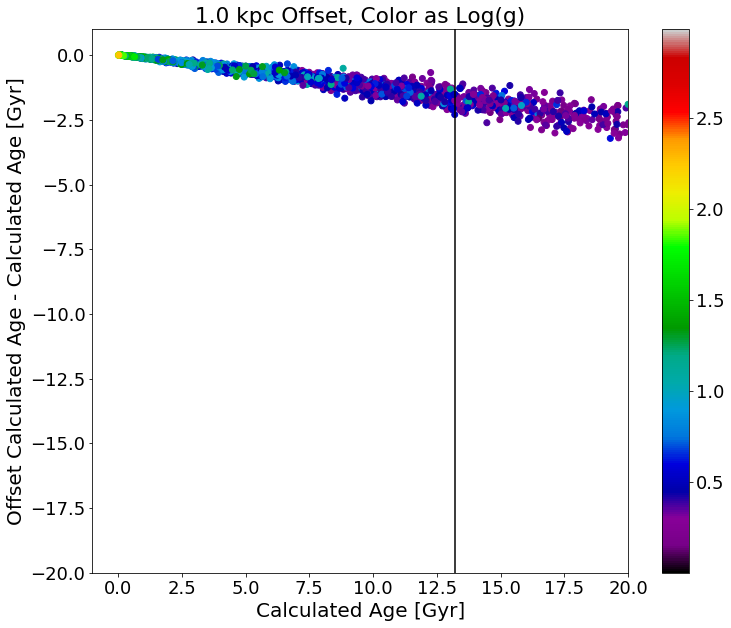

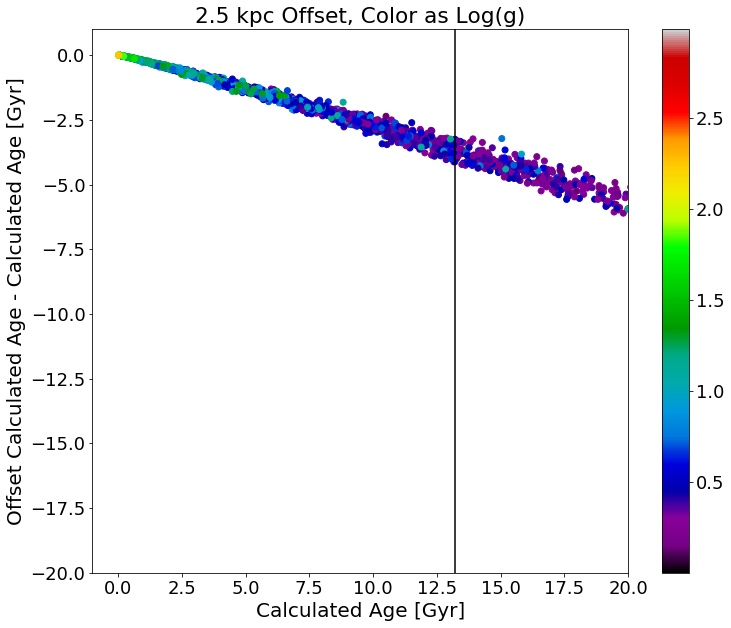

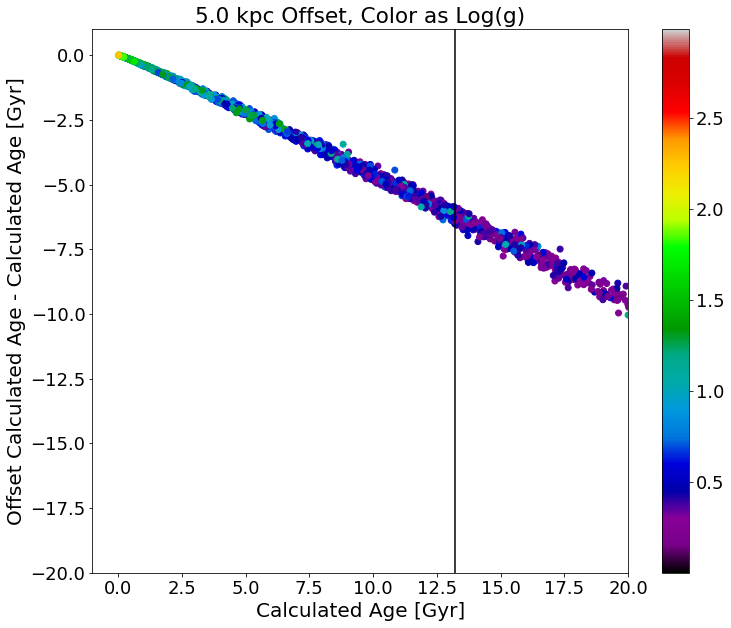

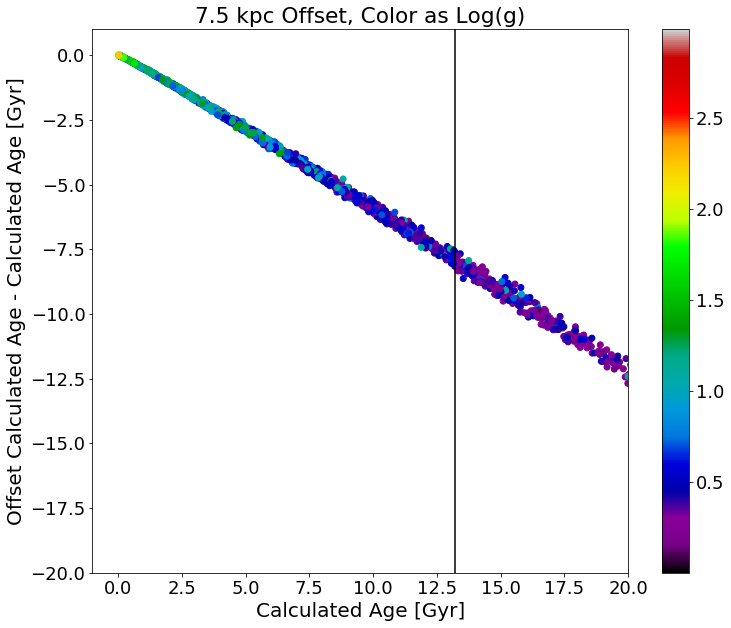

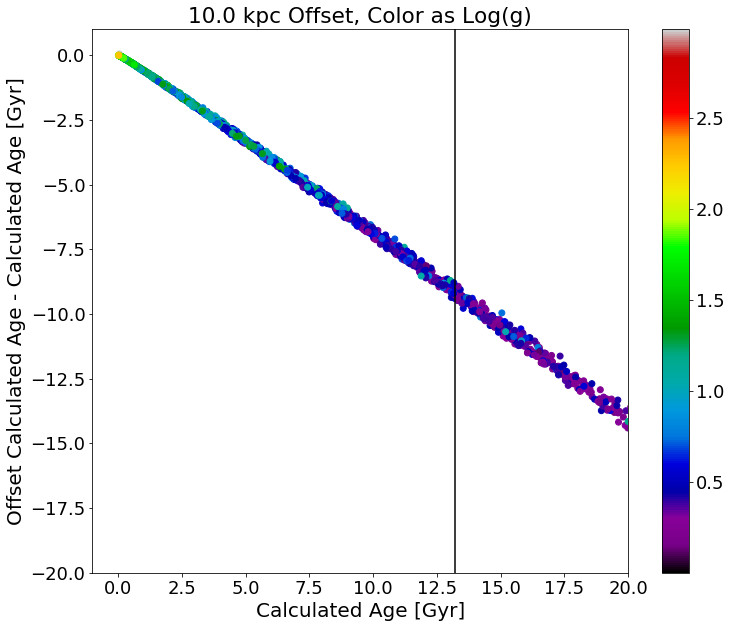

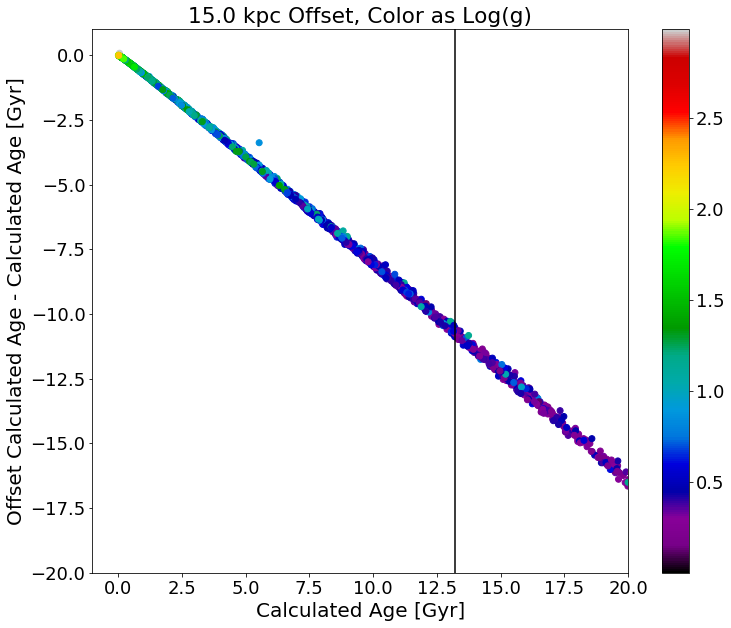

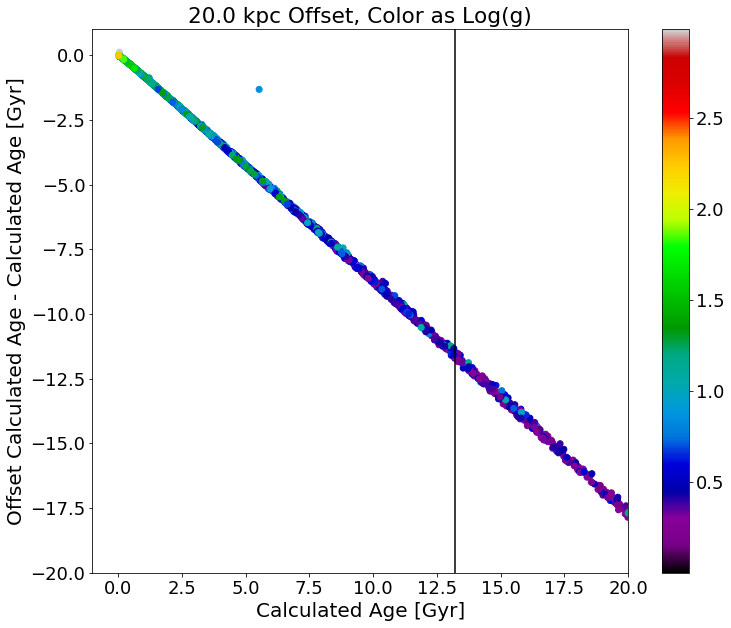

In [327]:
cp = 'nipy_spectral'

offsets = [1.0,2.5,5.0,7.5,10.0,15.0,20.0]

for i in range(len(gdiffs)):
    
    # setup
    plt.figure(figsize=[12,10])
    plt.title(r'{} kpc Offset, Color as Log(g)'.format(offsets[i]))
#     plt.xscale('log')
#     plt.yscale('log')
    
    plt.xlabel(r'Calculated Age [Gyr]',fontsize=20)
    plt.ylabel(r'Offset Calculated Age - Calculated Age [Gyr]',fontsize=20)
    
    plt.scatter(10**np.asarray(parages)/10**9,gdiffs[i],c=r13['LOGG'],cmap=cp,
                label='{} kpc Offset'.format(offsets[i]))
    
    plt.axvline(ageU/10**9,c='k')
    
#     plt.ylim(top=1.3)
    plt.xlim(-1,20)
    plt.ylim(-20,1)

    plt.colorbar()
    
#     plt.savefig('offset{}_vs_calc_age.pdf'.format(offsets[i]),bbox_inches='tight')

#     plt.legend(loc='lower right')
    plt.show()